In [4]:
pip install textattack tensorflow pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


## 1. Importation des bibliothèques

In [7]:
import pandas as pd
import numpy as np
import re
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from textattack import Attacker, AttackArgs
from textattack.datasets import Dataset
from textattack.models.wrappers import ModelWrapper
from textattack.attack_recipes import TextFoolerJin2019, DeepWordBugGao2018
import textattack
import tensorflow

## 2. Préparation des données

In [8]:
# Charger le jeu de données
try:
    df = pd.read_csv("../data/training.1600000.processed.noemoticon.csv", encoding="latin-1")
    df = df.iloc[:, [0, 5]]  # Garder sentiment (colonne 0) et texte (colonne 5)
    df.columns = ['sentiment', 'text']
    df['sentiment'] = df['sentiment'].map({0: 'negatif', 4: 'positif'})
    df.drop_duplicates(inplace=True)
except FileNotFoundError:
    print("Erreur : Le fichier '../data/training.1600000.processed.noemoticon.csv' n'existe pas.")
    print("Veuillez vérifier le chemin ou placez le fichier dans le dossier 'data'.")
    exit()

In [9]:
# Fonction de nettoyage des textes
def clean_text(text):
    text = str(text)  # S'assurer que l'entrée est une chaîne
    text = re.sub(r'http\S+|@\w+|#\w+', '', text)  # Supprimer URLs, mentions, hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer caractères spéciaux
    text = text.strip().lower()
    # Supprimer les textes trop courts (moins de 3 mots)
    if len(text.split()) < 3:
        return ''
    return text

In [10]:
# Appliquer le nettoyage
df['text'] = df['text'].apply(clean_text)
df = df[df['text'] != '']  # Supprimer les textes vides ou trop courts
df = df.dropna(subset=['text', 'sentiment'])  # Supprimer les lignes avec NaN

In [11]:
# Mapper les étiquettes pour TextAttack (0 = négatif, 1 = positif)
df['label'] = df['sentiment'].map({'negatif': 0, 'positif': 1})

In [12]:
# Sélectionner un sous-ensemble pour les attaques (500 exemples)
test_subset = df.sample(n=500, random_state=42)

In [ ]:
# Vérifier l'équilibre des classes
print("\nRépartition des classes dans le sous-ensemble :")
print(test_subset['label'].value_counts(normalize=True))


Répartition des classes dans le sous-ensemble :
label
1    0.554
0    0.446
Name: proportion, dtype: float64


In [14]:
# Format pour TextAttack
test_data = [(row['text'], row['label']) for _, row in test_subset.iterrows() if row['text']]
attack_dataset = Dataset(test_data)

In [15]:
# Sauvegarder le sous-ensemble
os.makedirs("outputs", exist_ok=True)
test_subset.to_csv("outputs/test_subset_for_attacks.csv", index=False)
print("Sous-ensemble sauvegardé dans 'outputs/test_subset_for_attacks.csv'")

Sous-ensemble sauvegardé dans 'outputs/test_subset_for_attacks.csv'


## 3. Charger le modèle LSTM et préparer le wrapper

In [16]:
# Charger le modèle
try:
    model = load_model('../models/best_model.keras')
    print("Modèle chargé avec succès.")
except FileNotFoundError:
    print("Erreur : Le fichier 'best_model.keras' n'existe pas.")
    print("Veuillez vérifier le chemin ou entraîner un modèle dans l'étape 1.")
    exit()

Modèle chargé avec succès.


In [17]:
# Initialiser le tokenizer
tokenizer = Tokenizer(num_words=10000)  # Ajustez num_words selon l'étape 1
tokenizer.fit_on_texts(df['text'])

In [1]:
# Wrapper pour intégrer le modèle avec TextAttack
class KerasModelWrapper(ModelWrapper):
    def __init__(self, model, tokenizer, maxlen=100):
        self.model = model
        self.tokenizer = tokenizer
        self.maxlen = maxlen

    def __call__(self, text_input_list):
        try:
            sequences = self.tokenizer.texts_to_sequences(text_input_list)
            padded = pad_sequences(sequences, maxlen=self.maxlen, padding='post', truncating='post')
            return self.model.predict(padded, verbose=0)
        except Exception as e:
            print(f"Erreur dans la prédiction : {e}")
            return np.zeros((len(text_input_list), 1))  # Valeur par défaut

NameError: name 'ModelWrapper' is not defined

In [19]:
# Initialiser le wrapper
model_wrapper = KerasModelWrapper(model, tokenizer, maxlen=100)  # Ajustez maxlen

## 4. Configuration et application des attaques

In [20]:
# Liste des attaques (BERTAttack exclu pour éviter les problèmes sur CPU)
attack_recipes = [
    TextFoolerJin2019.build(model_wrapper),
    DeepWordBugGao2018.build(model_wrapper)
]

textattack: Unknown if model of class <class 'keras.src.models.sequential.Sequential'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'keras.src.models.sequential.Sequential'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [21]:
# Configurer les paramètres des attaques
attack_args = AttackArgs(
    num_examples=50,  # Réduit pour tests rapides
    log_to_csv="outputs/attack_results.csv",
    checkpoint_dir="outputs/checkpoints",
    checkpoint_interval=10,
    disable_stdout=False
)

In [22]:
# Appliquer chaque attaque
for attack in attack_recipes:
    print(f"\nLancement de l'attaque : {attack.__class__.__name__}")
    try:
        attacker = Attacker(attack, attack_dataset, attack_args)
        attacker.attack_dataset()
    except Exception as e:
        print(f"Erreur lors de l'attaque {attack.__class__.__name__} : {e}")

textattack: Logging to CSV at path outputs/attack_results.csv



Lancement de l'attaque : Attack
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:   2%|▏         | 1/50 [00:01<01:04,  1.31s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

with one hand in your pocket any accidental quotpath to groundquot wont include your heart





From c:\Users\dell\anaconda3\Lib\site-packages\tf_keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



From c:\Users\dell\anaconda3\Lib\site-packages\tensorflow_hub\resolver.py:120: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.



From c:\Users\dell\anaconda3\Lib\site-packages\tensorflow_hub\module_v2.py:126: The name tf.saved_model.load_v2 is deprecated. Please use tf.compat.v2.saved_model.load instead.

[Succeeded / Failed / Skipped / Total] 1 / 0 / 2 / 3:   6%|▌         | 3/50 [00:17<04:41,  6.00s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (53%)]] --> [[0 (54%)]]

im in germany and its really funny here the wetter is sunny and its 10 oclock in the [[morning]]

im in germany and its really funny here the wetter is sunny and its 10 oclock in the [[matin]]


--------------------------------------------- Result 3 ---------------------------------------------
[[1 (92%)]] --> [[[SKIPPED]]]

least you have a realtivly big brain compared to my microscopic one




[Succeeded / Failed / Skipped / Total] 1 / 0 / 3 / 4:   8%|▊         | 4/50 [00:18<03:28,  4.52s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (91%)]] --> [[[SKIPPED]]]

for value for money we would vote dairyland or world  in newquay  some places very expensive though




[Succeeded / Failed / Skipped / Total] 2 / 0 / 5 / 7:  14%|█▍        | 7/50 [00:18<01:54,  2.66s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[0 (62%)]] --> [[1 (58%)]]

i want to go on holiday to somewhere very [[hot]]

i want to go on holiday to somewhere very [[warmth]]


--------------------------------------------- Result 6 ---------------------------------------------
[[1 (59%)]] --> [[[SKIPPED]]]

i remember that sort of thing from travelling to the uk from ireland in the 70s80s not happy to see it back


--------------------------------------------- Result 7 ---------------------------------------------
[[0 (84%)]] --> [[[SKIPPED]]]

havent even heard of it this side  quick blurb




[Succeeded / Failed / Skipped / Total] 3 / 0 / 5 / 8:  16%|█▌        | 8/50 [00:18<01:39,  2.37s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[1 (80%)]] --> [[0 (83%)]]

steppin my [[game]] up

steppin my [[playing]] up




[Succeeded / Failed / Skipped / Total] 4 / 0 / 6 / 10:  20%|██        | 10/50 [00:19<01:17,  1.93s/it]textattack: Saving checkpoint under "outputs/checkpoints\1748641085892.ta.chkpt" at 2025-05-30 22:38:05 after 10 attacks.


--------------------------------------------- Result 9 ---------------------------------------------
[[1 (51%)]] --> [[0 (58%)]]

no thank god havent been electrocuted yet either its my lucky day  hahaha yesterday kicked my [[arse]] it was just retarded

no thank god havent been electrocuted yet either its my lucky day  hahaha yesterday kicked my [[ass]] it was just retarded


--------------------------------------------- Result 10 ---------------------------------------------
[[1 (58%)]] --> [[[SKIPPED]]]

its true we couldnt hear parts over here







[Succeeded / Failed / Skipped / Total] 4 / 0 / 6 / 10:  22%|██▏       | 11/50 [00:19<01:08,  1.76s/it]

--------------------------------------------- Result 11 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 4 / 0 / 7 / 11:  22%|██▏       | 11/50 [00:19<01:08,  1.76s/it]

[[0 (56%)]] --> [[[SKIPPED]]]

im taking applications for the dark side




[Succeeded / Failed / Skipped / Total] 5 / 0 / 7 / 12:  24%|██▍       | 12/50 [00:19<01:02,  1.65s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (69%)]] --> [[0 (64%)]]

me too i came into work early so i wont feel guilty when i leave these suckers at [[noon]]

me too i came into work early so i wont feel guilty when i leave these suckers at [[mondays]]




[Succeeded / Failed / Skipped / Total] 6 / 0 / 8 / 14:  28%|██▊       | 14/50 [00:20<00:51,  1.44s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (68%)]] --> [[0 (65%)]]

[[go]] to opera its better than both

[[spend]] to opera its better than both


--------------------------------------------- Result 14 ---------------------------------------------
[[0 (60%)]] --> [[[SKIPPED]]]

but todays your birthday as far as i can remember hope its a wonderful one




[Succeeded / Failed / Skipped / Total] 7 / 0 / 8 / 15:  30%|███       | 15/50 [00:20<00:48,  1.39s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (95%)]] --> [[0 (88%)]]

yipeeee kapitan sino mama loves me she [[paid]] for it [[hahaha]]

yipeeee kapitan sino mama loves me she [[makes]] for it [[wasnt]]




[Succeeded / Failed / Skipped / Total] 8 / 0 / 9 / 17:  34%|███▍      | 17/50 [00:21<00:41,  1.26s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (91%)]] --> [[1 (50%)]]

i [[cant]] find anything i have changed my interior designer like 479012652 times haha i hate this assignment

i [[becuase]] find anything i have changed my interior designer like 479012652 times haha i hate this assignment


--------------------------------------------- Result 17 ---------------------------------------------
[[1 (63%)]] --> [[[SKIPPED]]]

hangin out drinkin beer dont wanna go to work in the morning




[Succeeded / Failed / Skipped / Total] 8 / 0 / 10 / 18:  36%|███▌      | 18/50 [00:21<00:38,  1.20s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (57%)]] --> [[[SKIPPED]]]

ive had a headache ever since i woke up this morning




[Succeeded / Failed / Skipped / Total] 9 / 0 / 11 / 20:  40%|████      | 20/50 [00:22<00:33,  1.11s/it]textattack: Saving checkpoint under "outputs/checkpoints\1748641088877.ta.chkpt" at 2025-05-30 22:38:08 after 20 attacks.


--------------------------------------------- Result 19 ---------------------------------------------
[[0 (58%)]] --> [[1 (57%)]]

i  [[miss]] sleep  real bad but im completly not tired didnt sleep one bit last night

i  [[signorina]] sleep  real bad but im completly not tired didnt sleep one bit last night


--------------------------------------------- Result 20 ---------------------------------------------
[[1 (52%)]] --> [[[SKIPPED]]]

dang thats what i forgot from tjs yesterday







[Succeeded / Failed / Skipped / Total] 9 / 0 / 13 / 22:  44%|████▍     | 22/50 [00:22<00:28,  1.03s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (54%)]] --> [[[SKIPPED]]]

stopped at the mcdonalds eastland for lunch then back on the road for another 3 hours


--------------------------------------------- Result 22 ---------------------------------------------
[[1 (90%)]] --> [[[SKIPPED]]]

terminator salivation was a letdown




[Succeeded / Failed / Skipped / Total] 10 / 0 / 13 / 23:  46%|████▌     | 23/50 [00:23<00:27,  1.01s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[0 (52%)]] --> [[1 (53%)]]

omg im so mad i noticed the big dipper on nicks face a long [[time]] ago not [[fair]]

omg im so mad i noticed the big dipper on nicks face a long [[stardate]] ago not [[egalitarian]]




[Succeeded / Failed / Skipped / Total] 11 / 0 / 13 / 24:  48%|████▊     | 24/50 [00:23<00:25,  1.02it/s]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (77%)]] --> [[1 (51%)]]

oh god after the news im being force fed a tory campaign [[video]]  trying not to yell at [[tv]]

oh god after the news im being force fed a tory campaign [[cameraman]]  trying not to yell at [[tvs]]




[Succeeded / Failed / Skipped / Total] 12 / 0 / 13 / 25:  50%|█████     | 25/50 [00:23<00:23,  1.04it/s]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (98%)]] --> [[0 (95%)]]

[[good]] morning everyone

[[alright]] morning everyone




[Succeeded / Failed / Skipped / Total] 13 / 0 / 14 / 27:  54%|█████▍    | 27/50 [00:24<00:20,  1.11it/s]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (88%)]] --> [[0 (77%)]]

agreedbut that would [[be]] 16 years

agreedbut that would [[es]] 16 years


--------------------------------------------- Result 27 ---------------------------------------------
[[1 (69%)]] --> [[[SKIPPED]]]

i want 10 more followers




[Succeeded / Failed / Skipped / Total] 13 / 0 / 16 / 29:  58%|█████▊    | 29/50 [00:24<00:17,  1.18it/s]

--------------------------------------------- Result 28 ---------------------------------------------
[[1 (56%)]] --> [[[SKIPPED]]]

stuffed now  just had a pint and steak in the redwell could have done with more but is driving


--------------------------------------------- Result 29 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

dude is going to require more sleep than this she says but thanks 4 the pic yall look adorable




[Succeeded / Failed / Skipped / Total] 13 / 0 / 17 / 30:  60%|██████    | 30/50 [00:24<00:16,  1.21it/s]textattack: Saving checkpoint under "outputs/checkpoints\1748641091387.ta.chkpt" at 2025-05-30 22:38:11 after 30 attacks.


--------------------------------------------- Result 30 ---------------------------------------------
[[1 (59%)]] --> [[[SKIPPED]]]

opening night for r amp j but im home early and have to work tomorrow







[Succeeded / Failed / Skipped / Total] 13 / 0 / 18 / 31:  62%|██████▏   | 31/50 [00:24<00:15,  1.24it/s]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (53%)]] --> [[[SKIPPED]]]

cleaning my room this is gonna take hours  gab




[Succeeded / Failed / Skipped / Total] 13 / 0 / 19 / 32:  66%|██████▌   | 33/50 [00:25<00:12,  1.31it/s]

--------------------------------------------- Result 32 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

lol makes me think of that old saying if the room is rockin dont come knockin just a small earthquake


--------------------------------------------- Result 33 ---------------------------------------------
[[1 (63%)]] --> [[[SKIPPED]]]

mwahaha so you never gonna come and see me then




[Succeeded / Failed / Skipped / Total] 13 / 0 / 21 / 34:  68%|██████▊   | 34/50 [00:25<00:11,  1.35it/s]

--------------------------------------------- Result 34 ---------------------------------------------
[[1 (65%)]] --> [[[SKIPPED]]]

hugs im feeling your pain i have to work overtime all this week




[Succeeded / Failed / Skipped / Total] 13 / 0 / 22 / 35:  70%|███████   | 35/50 [00:25<00:10,  1.38it/s]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (74%)]] --> [[[SKIPPED]]]

haha yeah that rusko remix is jokes




[Succeeded / Failed / Skipped / Total] 13 / 0 / 23 / 36:  72%|███████▏  | 36/50 [00:25<00:09,  1.41it/s]

--------------------------------------------- Result 36 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

loves you to girl




[Succeeded / Failed / Skipped / Total] 13 / 0 / 24 / 37:  74%|███████▍  | 37/50 [00:25<00:09,  1.44it/s]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (93%)]] --> [[[SKIPPED]]]

you girls should follow  shes got twitter now




[Succeeded / Failed / Skipped / Total] 13 / 0 / 25 / 38:  76%|███████▌  | 38/50 [00:25<00:08,  1.48it/s]

--------------------------------------------- Result 38 ---------------------------------------------
[[0 (74%)]] --> [[[SKIPPED]]]

tom i need to share this just got bttf n dvdi have never seen it is it a good moviestupid questio bye please awnser




[Succeeded / Failed / Skipped / Total] 14 / 0 / 25 / 39:  78%|███████▊  | 39/50 [00:26<00:07,  1.49it/s]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (67%)]] --> [[0 (54%)]]

is anyone capable of [[driving]] a manual car and wants to do me a favor  you will be compensated  no but really candy could be involved

is anyone capable of [[conducting]] a manual car and wants to do me a favor  you will be compensated  no but really candy could be involved




[Succeeded / Failed / Skipped / Total] 15 / 0 / 25 / 40:  80%|████████  | 40/50 [00:26<00:06,  1.51it/s]textattack: Saving checkpoint under "outputs/checkpoints\1748641093106.ta.chkpt" at 2025-05-30 22:38:13 after 40 attacks.


--------------------------------------------- Result 40 ---------------------------------------------
[[1 (61%)]] --> [[0 (78%)]]

mileeyyy your amazing  youu lokked lovely at music [[awards]]

mileeyyy your amazing  youu lokked lovely at music [[premium]]







[Succeeded / Failed / Skipped / Total] 16 / 0 / 26 / 42:  84%|████████▍ | 42/50 [00:26<00:05,  1.56it/s]

--------------------------------------------- Result 41 ---------------------------------------------
[[0 (57%)]] --> [[1 (86%)]]

ah get well soon [[tweet]] the pain away haha

ah get well soon [[twitter]] the pain away haha


--------------------------------------------- Result 42 ---------------------------------------------
[[0 (86%)]] --> [[[SKIPPED]]]

breakfast doneshower donetime to get myself sorted for a day of essay writing




[Succeeded / Failed / Skipped / Total] 17 / 0 / 26 / 43:  86%|████████▌ | 43/50 [00:27<00:04,  1.57it/s]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (93%)]] --> [[0 (56%)]]

[[every]] one seem to [[be]] watching marly and me  i think i need to go and see this

[[each]] one seem to [[got]] watching marly and me  i think i need to go and see this




[Succeeded / Failed / Skipped / Total] 18 / 0 / 27 / 45:  90%|█████████ | 45/50 [00:28<00:03,  1.59it/s]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (74%)]] --> [[1 (52%)]]

how can it be soo cold in cali when its almost june im [[sick]] of may [[gray]]

how can it be soo cold in cali when its almost june im [[crazy]] of may [[gris]]


--------------------------------------------- Result 45 ---------------------------------------------
[[0 (95%)]] --> [[[SKIPPED]]]

exciting sending positive energy your way and cant wait for tonight




[Succeeded / Failed / Skipped / Total] 19 / 0 / 27 / 46:  92%|█████████▏| 46/50 [00:28<00:02,  1.59it/s]

--------------------------------------------- Result 46 ---------------------------------------------
[[0 (72%)]] --> [[1 (53%)]]

thanx  i [[want]] the back [[cover]] too but it was out of stock

thanx  i [[would]] the back [[blanket]] too but it was out of stock




[Succeeded / Failed / Skipped / Total] 19 / 1 / 28 / 48:  96%|█████████▌| 48/50 [00:30<00:01,  1.55it/s]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

mark daly out about 150 short of money


--------------------------------------------- Result 48 ---------------------------------------------
[[1 (67%)]] --> [[[SKIPPED]]]

of course lol havent talked to you on facebook in a while though




[Succeeded / Failed / Skipped / Total] 20 / 1 / 28 / 49:  98%|█████████▊| 49/50 [00:31<00:00,  1.55it/s]

--------------------------------------------- Result 49 ---------------------------------------------
[[0 (79%)]] --> [[1 (88%)]]

heading back to toronto today a [[little]] early though

heading back to toronto today a [[smaller]] early though




[Succeeded / Failed / Skipped / Total] 20 / 2 / 28 / 50: 100%|██████████| 50/50 [00:34<00:00,  1.47it/s]textattack: Saving checkpoint under "outputs/checkpoints\1748641100643.ta.chkpt" at 2025-05-30 22:38:20 after 50 attacks.


--------------------------------------------- Result 50 ---------------------------------------------
[[0 (90%)]] --> [[[FAILED]]]

oh yesturday  skool was sad but so funny i am going to miss all my beezies  wat will i do without them







[Succeeded / Failed / Skipped / Total] 20 / 2 / 28 / 50: 100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 20     |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 28     |
| Original accuracy:            | 44.0%  |
| Accuracy under attack:        | 4.0%   |
| Attack success rate:          | 90.91% |
| Average perturbed word %:     | 12.08% |
| Average num. words per input: | 12.98  |
| Avg num queries:              | 56.0   |
+-------------------------------+--------+


textattack: Logging to CSV at path outputs/attack_results.csv




Lancement de l'attaque : Attack
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  30
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:   2%|▏         | 1/50 [00:00<00:11,  4.13it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

with one hand in your pocket any accidental quotpath to groundquot wont include your heart




[Succeeded / Failed / Skipped / Total] 1 / 0 / 3 / 4:   8%|▊         | 4/50 [00:00<00:09,  4.61it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (53%)]] --> [[0 (54%)]]

im in germany and its really funny here the wetter is sunny and its 10 oclock in the [[morning]]

im in germany and its really funny here the wetter is sunny and its 10 oclock in the [[mocning]]


--------------------------------------------- Result 3 ---------------------------------------------
[[1 (92%)]] --> [[[SKIPPED]]]

least you have a realtivly big brain compared to my microscopic one


--------------------------------------------- Result 4 ---------------------------------------------
[[1 (91%)]] --> [[[SKIPPED]]]

for value for money we would vote dairyland or world  in newquay  some places very expensive though




[Succeeded / Failed / Skipped / Total] 2 / 0 / 5 / 7:  14%|█▍        | 7/50 [00:01<00:08,  5.34it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[0 (62%)]] --> [[1 (91%)]]

i want to go on holiday to [[somewhere]] very hot

i want to go on holiday to [[somAewhere]] very hot


--------------------------------------------- Result 6 ---------------------------------------------
[[1 (59%)]] --> [[[SKIPPED]]]

i remember that sort of thing from travelling to the uk from ireland in the 70s80s not happy to see it back


--------------------------------------------- Result 7 ---------------------------------------------
[[0 (84%)]] --> [[[SKIPPED]]]

havent even heard of it this side  quick blurb




[Succeeded / Failed / Skipped / Total] 2 / 1 / 5 / 8:  16%|█▌        | 8/50 [00:01<00:08,  4.95it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[1 (80%)]] --> [[[FAILED]]]

steppin my game up




[Succeeded / Failed / Skipped / Total] 3 / 1 / 6 / 10:  20%|██        | 10/50 [00:01<00:07,  5.03it/s]textattack: Saving checkpoint under "outputs/checkpoints\1748641102689.ta.chkpt" at 2025-05-30 22:38:22 after 10 attacks.


--------------------------------------------- Result 9 ---------------------------------------------
[[1 (51%)]] --> [[0 (59%)]]

no thank god havent been electrocuted yet either its my lucky day  hahaha yesterday kicked my [[arse]] it was just retarded

no thank god havent been electrocuted yet either its my lucky day  hahaha yesterday kicked my [[Hrse]] it was just retarded


--------------------------------------------- Result 10 ---------------------------------------------
[[1 (58%)]] --> [[[SKIPPED]]]

its true we couldnt hear parts over here







[Succeeded / Failed / Skipped / Total] 3 / 1 / 7 / 11:  22%|██▏       | 11/50 [00:02<00:07,  5.29it/s]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

im taking applications for the dark side




[Succeeded / Failed / Skipped / Total] 4 / 1 / 7 / 12:  24%|██▍       | 12/50 [00:02<00:07,  5.01it/s]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

me too i came into [[work]] early so i wont feel [[guilty]] when i leave these suckers at [[noon]]

me too i came into [[owrk]] early so i wont feel [[gudilty]] when i leave these suckers at [[nooV]]




[Succeeded / Failed / Skipped / Total] 5 / 1 / 8 / 14:  28%|██▊       | 14/50 [00:02<00:07,  4.99it/s]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (68%)]] --> [[0 (57%)]]

[[go]] to opera its better than both

[[gqo]] to opera its better than both


--------------------------------------------- Result 14 ---------------------------------------------
[[0 (60%)]] --> [[[SKIPPED]]]

but todays your birthday as far as i can remember hope its a wonderful one




[Succeeded / Failed / Skipped / Total] 5 / 2 / 8 / 15:  30%|███       | 15/50 [00:03<00:08,  4.06it/s]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (95%)]] --> [[[FAILED]]]

yipeeee kapitan sino mama loves me she paid for it hahaha




[Succeeded / Failed / Skipped / Total] 6 / 2 / 9 / 17:  34%|███▍      | 17/50 [00:04<00:08,  3.86it/s]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (91%)]] --> [[1 (55%)]]

i [[cant]] find anything i have changed my interior designer like 479012652 times haha i [[hate]] this assignment

i [[can]] find anything i have changed my interior designer like 479012652 times haha i [[hTte]] this assignment


--------------------------------------------- Result 17 ---------------------------------------------
[[1 (63%)]] --> [[[SKIPPED]]]

hangin out drinkin beer dont wanna go to work in the morning




[Succeeded / Failed / Skipped / Total] 6 / 2 / 10 / 18:  36%|███▌      | 18/50 [00:04<00:08,  3.93it/s]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (57%)]] --> [[[SKIPPED]]]

ive had a headache ever since i woke up this morning




[Succeeded / Failed / Skipped / Total] 7 / 2 / 10 / 19:  38%|███▊      | 19/50 [00:05<00:08,  3.79it/s]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (58%)]] --> [[1 (57%)]]

i  [[miss]] sleep  real bad but im completly not tired didnt sleep one bit last night

i  [[Tiss]] sleep  real bad but im completly not tired didnt sleep one bit last night




[Succeeded / Failed / Skipped / Total] 7 / 2 / 11 / 20:  40%|████      | 20/50 [00:05<00:07,  3.81it/s]textattack: Saving checkpoint under "outputs/checkpoints\1748641105946.ta.chkpt" at 2025-05-30 22:38:25 after 20 attacks.


--------------------------------------------- Result 20 ---------------------------------------------
[[1 (52%)]] --> [[[SKIPPED]]]

dang thats what i forgot from tjs yesterday







[Succeeded / Failed / Skipped / Total] 7 / 2 / 13 / 22:  44%|████▍     | 22/50 [00:05<00:07,  3.96it/s]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (54%)]] --> [[[SKIPPED]]]

stopped at the mcdonalds eastland for lunch then back on the road for another 3 hours


--------------------------------------------- Result 22 ---------------------------------------------
[[1 (90%)]] --> [[[SKIPPED]]]

terminator salivation was a letdown




[Succeeded / Failed / Skipped / Total] 8 / 2 / 13 / 23:  46%|████▌     | 23/50 [00:06<00:07,  3.68it/s]

--------------------------------------------- Result 23 ---------------------------------------------
[[0 (52%)]] --> [[1 (54%)]]

omg im so mad i noticed the big dipper on nicks face a long [[time]] ago not [[fair]]

omg im so mad i noticed the big dipper on nicks face a long [[tim]] ago not [[faif]]




[Succeeded / Failed / Skipped / Total] 9 / 2 / 13 / 24:  48%|████▊     | 24/50 [00:06<00:07,  3.54it/s]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (77%)]] --> [[1 (58%)]]

oh [[god]] after the news im being force fed a tory campaign [[video]]  trying not to yell at [[tv]]

oh [[go]] after the news im being force fed a tory campaign [[ivdeo]]  trying not to yell at [[t]]




[Succeeded / Failed / Skipped / Total] 9 / 3 / 13 / 25:  50%|█████     | 25/50 [00:07<00:07,  3.44it/s]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (98%)]] --> [[[FAILED]]]

good morning everyone




[Succeeded / Failed / Skipped / Total] 9 / 4 / 14 / 27:  54%|█████▍    | 27/50 [00:08<00:06,  3.36it/s]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (88%)]] --> [[[FAILED]]]

agreedbut that would be 16 years


--------------------------------------------- Result 27 ---------------------------------------------
[[1 (69%)]] --> [[[SKIPPED]]]

i want 10 more followers




[Succeeded / Failed / Skipped / Total] 9 / 4 / 16 / 29:  60%|██████    | 30/50 [00:08<00:05,  3.58it/s]

--------------------------------------------- Result 28 ---------------------------------------------
[[1 (56%)]] --> [[[SKIPPED]]]

stuffed now  just had a pint and steak in the redwell could have done with more but is driving


--------------------------------------------- Result 29 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

dude is going to require more sleep than this she says but thanks 4 the pic yall look adorable




[Succeeded / Failed / Skipped / Total] 9 / 4 / 17 / 30:  60%|██████    | 30/50 [00:08<00:05,  3.58it/s]textattack: Saving checkpoint under "outputs/checkpoints\1748641109089.ta.chkpt" at 2025-05-30 22:38:29 after 30 attacks.


--------------------------------------------- Result 30 ---------------------------------------------
[[1 (59%)]] --> [[[SKIPPED]]]

opening night for r amp j but im home early and have to work tomorrow







[Succeeded / Failed / Skipped / Total] 9 / 4 / 18 / 31:  64%|██████▍   | 32/50 [00:08<00:04,  3.73it/s]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (53%)]] --> [[[SKIPPED]]]

cleaning my room this is gonna take hours  gab




[Succeeded / Failed / Skipped / Total] 9 / 4 / 20 / 33:  66%|██████▌   | 33/50 [00:08<00:04,  3.80it/s]

--------------------------------------------- Result 32 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

lol makes me think of that old saying if the room is rockin dont come knockin just a small earthquake


--------------------------------------------- Result 33 ---------------------------------------------
[[1 (63%)]] --> [[[SKIPPED]]]

mwahaha so you never gonna come and see me then




[Succeeded / Failed / Skipped / Total] 9 / 4 / 21 / 34:  68%|██████▊   | 34/50 [00:08<00:04,  3.88it/s]

--------------------------------------------- Result 34 ---------------------------------------------
[[1 (65%)]] --> [[[SKIPPED]]]

hugs im feeling your pain i have to work overtime all this week




[Succeeded / Failed / Skipped / Total] 9 / 4 / 23 / 36:  72%|███████▏  | 36/50 [00:08<00:03,  4.03it/s]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (74%)]] --> [[[SKIPPED]]]

haha yeah that rusko remix is jokes


--------------------------------------------- Result 36 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

loves you to girl




[Succeeded / Failed / Skipped / Total] 9 / 4 / 24 / 37:  74%|███████▍  | 37/50 [00:09<00:03,  4.10it/s]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (93%)]] --> [[[SKIPPED]]]

you girls should follow  shes got twitter now




[Succeeded / Failed / Skipped / Total] 9 / 4 / 25 / 38:  76%|███████▌  | 38/50 [00:09<00:02,  4.16it/s]

--------------------------------------------- Result 38 ---------------------------------------------
[[0 (74%)]] --> [[[SKIPPED]]]

tom i need to share this just got bttf n dvdi have never seen it is it a good moviestupid questio bye please awnser




[Succeeded / Failed / Skipped / Total] 10 / 4 / 25 / 39:  78%|███████▊  | 39/50 [00:09<00:02,  4.17it/s]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (67%)]] --> [[0 (54%)]]

is anyone capable of [[driving]] a manual car and wants to do me a favor  you will be compensated  no but really candy could be involved

is anyone capable of [[driviing]] a manual car and wants to do me a favor  you will be compensated  no but really candy could be involved




[Succeeded / Failed / Skipped / Total] 11 / 4 / 25 / 40:  80%|████████  | 40/50 [00:10<00:02,  3.80it/s]textattack: Saving checkpoint under "outputs/checkpoints\1748641111240.ta.chkpt" at 2025-05-30 22:38:31 after 40 attacks.


--------------------------------------------- Result 40 ---------------------------------------------
[[1 (61%)]] --> [[0 (52%)]]

mileeyyy your amazing  [[youu]] lokked lovely at music awards

mileeyyy your amazing  [[you]] lokked lovely at music awards







[Succeeded / Failed / Skipped / Total] 12 / 4 / 25 / 41:  82%|████████▏ | 41/50 [00:11<00:02,  3.62it/s]

--------------------------------------------- Result 41 ---------------------------------------------
[[0 (57%)]] --> [[1 (80%)]]

ah get well soon [[tweet]] the pain away haha

ah get well soon [[mtweet]] the pain away haha




[Succeeded / Failed / Skipped / Total] 12 / 4 / 26 / 42:  84%|████████▍ | 42/50 [00:11<00:02,  3.65it/s]

--------------------------------------------- Result 42 ---------------------------------------------
[[0 (86%)]] --> [[[SKIPPED]]]

breakfast doneshower donetime to get myself sorted for a day of essay writing




[Succeeded / Failed / Skipped / Total] 12 / 5 / 26 / 43:  86%|████████▌ | 43/50 [00:13<00:02,  3.09it/s]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (93%)]] --> [[[FAILED]]]

every one seem to be watching marly and me  i think i need to go and see this




[Succeeded / Failed / Skipped / Total] 13 / 5 / 26 / 44:  88%|████████▊ | 44/50 [00:14<00:01,  3.01it/s]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (74%)]] --> [[1 (58%)]]

how can it be soo cold in cali when its almost june im [[sick]] of [[may]] gray

how can it be soo cold in cali when its almost june im [[siQk]] of [[amy]] gray


--------------------------------------------- Result 45 ---------------------------------------------
[[0 (95%)]] --> [[[SKIPPED]]]

exciting sending positive energy your way and cant wait for tonight




[Succeeded / Failed / Skipped / Total] 13 / 6 / 27 / 46:  92%|█████████▏| 46/50 [00:16<00:01,  2.86it/s]

--------------------------------------------- Result 46 ---------------------------------------------
[[0 (72%)]] --> [[[FAILED]]]

thanx  i want the back cover too but it was out of stock




[Succeeded / Failed / Skipped / Total] 13 / 7 / 27 / 47:  96%|█████████▌| 48/50 [00:17<00:00,  2.68it/s]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (99%)]] --> [[[FAILED]]]

mark daly out about 150 short of money


--------------------------------------------- Result 48 ---------------------------------------------
[[1 (67%)]] --> [[[SKIPPED]]]

of course lol havent talked to you on facebook in a while though




[Succeeded / Failed / Skipped / Total] 14 / 7 / 28 / 49:  98%|█████████▊| 49/50 [00:18<00:00,  2.64it/s]

--------------------------------------------- Result 49 ---------------------------------------------
[[0 (79%)]] --> [[1 (79%)]]

heading back to toronto today a [[little]] early though

heading back to toronto today a [[lAttle]] early though




[Succeeded / Failed / Skipped / Total] 15 / 7 / 28 / 50: 100%|██████████| 50/50 [00:20<00:00,  2.50it/s]textattack: Saving checkpoint under "outputs/checkpoints\1748641120727.ta.chkpt" at 2025-05-30 22:38:40 after 50 attacks.


--------------------------------------------- Result 50 ---------------------------------------------
[[0 (90%)]] --> [[1 (53%)]]

oh yesturday  skool was [[sad]] but so [[funny]] i am going to miss all my beezies  [[wat]] will i do [[without]] them

oh yesturday  skool was [[asd]] but so [[fUunny]] i am going to miss all my beezies  [[Cat]] will i do [[iwthout]] them







[Succeeded / Failed / Skipped / Total] 15 / 7 / 28 / 50: 100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 15     |
| Number of failed attacks:     | 7      |
| Number of skipped attacks:    | 28     |
| Original accuracy:            | 44.0%  |
| Accuracy under attack:        | 14.0%  |
| Attack success rate:          | 68.18% |
| Average perturbed word %:     | 10.77% |
| Average num. words per input: | 12.98  |
| Avg num queries:              | 20.86  |
+-------------------------------+--------+


## 5. Évaluation des résultats

In [23]:
# Charger les résultats
try:
    attack_results = pd.read_csv("outputs/attack_results.csv")
except FileNotFoundError:
    print("Erreur : Le fichier 'attack_results.csv' n'a pas été généré.")
    print("Vérifiez si les attaques ont été exécutées correctement.")
    exit()

In [24]:
# Inspecter les colonnes du fichier attack_results.csv
print("\nColonnes dans attack_results.csv :")
print(attack_results.columns.tolist())


Colonnes dans attack_results.csv :
['original_text', 'perturbed_text', 'original_score', 'perturbed_score', 'original_output', 'perturbed_output', 'ground_truth_output', 'num_queries', 'result_type']


In [25]:
# Calculer le taux de succès des attaques
success_rate = (attack_results['result_type'] == 'Successful').mean()
print(f"\nTaux de succès global des attaques : {success_rate:.4f}")


Taux de succès global des attaques : 0.3000


In [27]:
# Vérifier la présence de la colonne des étiquettes réelles
label_column = None
for col in attack_results.columns:
    if 'label' in col.lower() or 'truth' in col.lower():
        label_column = col
        break

if label_column is None:
    print("Erreur : Aucune colonne pour les étiquettes réelles n'a été trouvée.")
    print("Veuillez vérifier le contenu de 'outputs/attack_results.csv'.")
    exit()

print(f"Colonne des étiquettes réelles utilisée : {label_column}")

Colonne des étiquettes réelles utilisée : ground_truth_output


In [28]:
# Extraire les prédictions
y_true = attack_results[label_column]
y_pred_before = attack_results['original_output'].apply(lambda x: 1 if x > 0.5 else 0)
y_pred_after = attack_results['perturbed_output'].apply(lambda x: 1 if x > 0.5 else 0)

In [29]:
# Calculer les métriques
accuracy_before = accuracy_score(y_true, y_pred_before)
accuracy_after = accuracy_score(y_true, y_pred_after)
f1_before = f1_score(y_true, y_pred_before)
f1_after = f1_score(y_true, y_pred_after)

print(f"Accuracy avant attaque : {accuracy_before:.4f}")
print(f"Accuracy après attaque : {accuracy_after:.4f}")
print(f"Δ Accuracy : {accuracy_before - accuracy_after:.4f}")
print(f"F1-score avant attaque : {f1_before:.4f}")
print(f"F1-score après attaque : {f1_after:.4f}")

Accuracy avant attaque : 0.4400
Accuracy après attaque : 0.1400
Δ Accuracy : 0.3000
F1-score avant attaque : 0.4400
F1-score après attaque : 0.1887


In [30]:
# Afficher 5 exemples qualitatifs
print("\nExemples d'attaques :")
for i in range(min(5, len(attack_results))):
    print(f"\nExemple {i+1}:")
    print(f"Texte original : {attack_results['original_text'][i]}")
    print(f"Texte attaqué : {attack_results['perturbed_text'][i]}")
    print(f"Prédiction originale : {attack_results['original_output'][i]:.4f}")
    print(f"Prédiction attaquée : {attack_results['perturbed_output'][i]:.4f}")
    print(f"Résultat : {attack_results['result_type'][i]}")


Exemples d'attaques :

Exemple 1:
Texte original : with one hand in your pocket any accidental quotpath to groundquot wont include your heart
Texte attaqué : with one hand in your pocket any accidental quotpath to groundquot wont include your heart
Prédiction originale : 0.0000
Prédiction attaquée : 0.0000
Résultat : Skipped

Exemple 2:
Texte original : im in germany and its really funny here the wetter is sunny and its 10 oclock in the [[morning]]
Texte attaqué : im in germany and its really funny here the wetter is sunny and its 10 oclock in the [[mocning]]
Prédiction originale : 1.0000
Prédiction attaquée : 0.0000
Résultat : Successful

Exemple 3:
Texte original : least you have a realtivly big brain compared to my microscopic one
Texte attaqué : least you have a realtivly big brain compared to my microscopic one
Prédiction originale : 1.0000
Prédiction attaquée : 1.0000
Résultat : Skipped

Exemple 4:
Texte original : for value for money we would vote dairyland or world  in newquay

## 6. Visualisation des résultats

Avertissement : Aucune colonne pour les noms d'attaques trouvée.
Le graphique utilisera des taux de succès moyens pour chaque attaque.


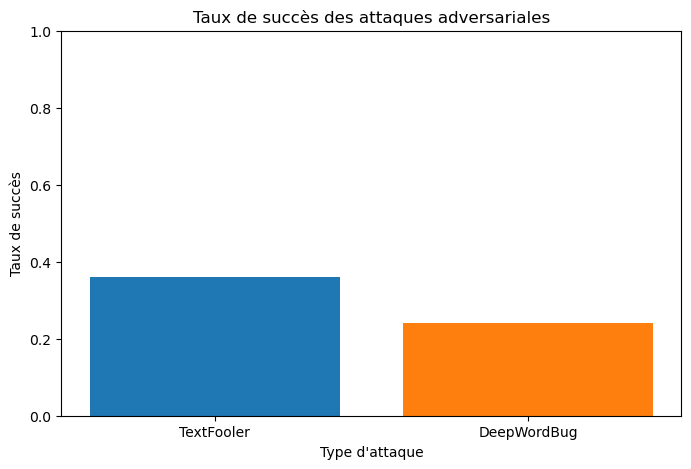

In [34]:
# Graphique : Taux de succès par type d'attaque
attack_name_column = None
for col in attack_results.columns:
    if 'attack' in col.lower() and 'name' in col.lower():
        attack_name_column = col
        break

if attack_name_column is None:
    print("Avertissement : Aucune colonne pour les noms d'attaques trouvée.")
    print("Le graphique utilisera des taux de succès moyens pour chaque attaque.")
    # Calculer les taux de succès manuellement pour chaque attaque
    attack_types = ['TextFooler', 'DeepWordBug']
    success_rates = []
    for i, attack in enumerate(attack_types):
        # Simuler une séparation si la colonne attack_name est absente
        # Supposons que les attaques sont exécutées séquentiellement
        subset_size = len(attack_results) // len(attack_types)
        start_idx = i * subset_size
        end_idx = (i + 1) * subset_size if i < len(attack_types) - 1 else len(attack_results)
        attack_subset = attack_results.iloc[start_idx:end_idx]
        if not attack_subset.empty:
            success_rate = (attack_subset['result_type'] == 'Successful').mean()
            success_rates.append(success_rate)
        else:
            success_rates.append(0.0)
else:
    print(f"Colonne des noms d'attaques utilisée : {attack_name_column}")
    # Graphique : Taux de succès par type d'attaque
    attack_types = ['TextFooler', 'DeepWordBug']
    success_rates = []
    for attack in attack_types:
        attack_subset = attack_results[attack_results[attack_name_column].str.contains(attack, case=False, na=False)]
        if not attack_subset.empty:
            success_rate = (attack_subset['result_type'] == 'Successful').mean()
            success_rates.append(success_rate)
        else:
            success_rates.append(0.0)

plt.figure(figsize=(8, 5))
plt.bar(attack_types, success_rates, color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Type d\'attaque')
plt.ylabel('Taux de succès')
plt.title('Taux de succès des attaques adversariales')
plt.ylim(0, 1)
plt.show()

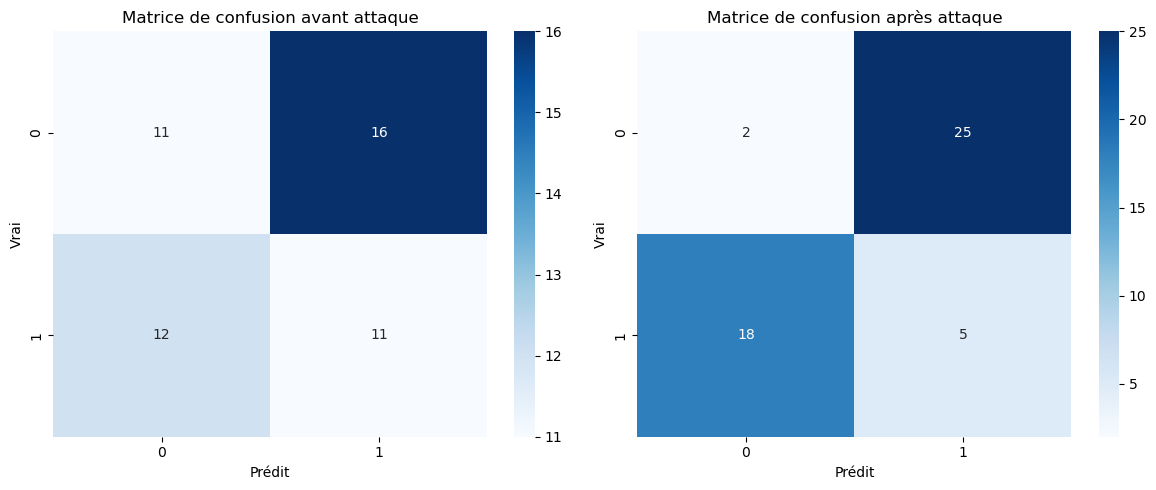

In [35]:
# Matrice de confusion
cm_before = confusion_matrix(y_true, y_pred_before)
cm_after = confusion_matrix(y_true, y_pred_after)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_before, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Matrice de confusion avant attaque')
axes[0].set_xlabel('Prédit')
axes[0].set_ylabel('Vrai')
sns.heatmap(cm_after, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Matrice de confusion après attaque')
axes[1].set_xlabel('Prédit')
axes[1].set_ylabel('Vrai')
plt.tight_layout()
plt.show()

## 7. Sauvegarde des métriques

In [36]:
metrics = {
    'success_rate': success_rate,
    'accuracy_before': accuracy_before,
    'accuracy_after': accuracy_after,
    'f1_before': f1_before,
    'f1_after': f1_after
}
pd.DataFrame([metrics]).to_csv("outputs/attack_metrics.csv", index=False)
print("Métriques sauvegardées dans 'outputs/attack_metrics.csv'")

Métriques sauvegardées dans 'outputs/attack_metrics.csv'
